In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Кластеризация

Наша задача - предсказать есть диабет у индивида или нет. В качестве таргета - колонка Diabetes. В нем три различных значения: `0`, `1`, `2`. `0` означает, что наблюдаемой здоров, `1` значит, что есть риск диабета, `2` означает наличие диабета. В качестве признаков будем использовать пол, количество лет в США, доход семьи и некоторые показатели, измеренные медицинскими работниками.  

**Задание 1.** В этой части ДЗ попробуем использовать кластеризацию как инструмент при проведении моделирования в задаче классификации

In [7]:
df = pd.read_csv('datahw21.csv', index_col='Unnamed: 0')

df.head()

df[df['Family_income'] > 4].to_csv('test.csv', index=False)

<AxesSubplot: >

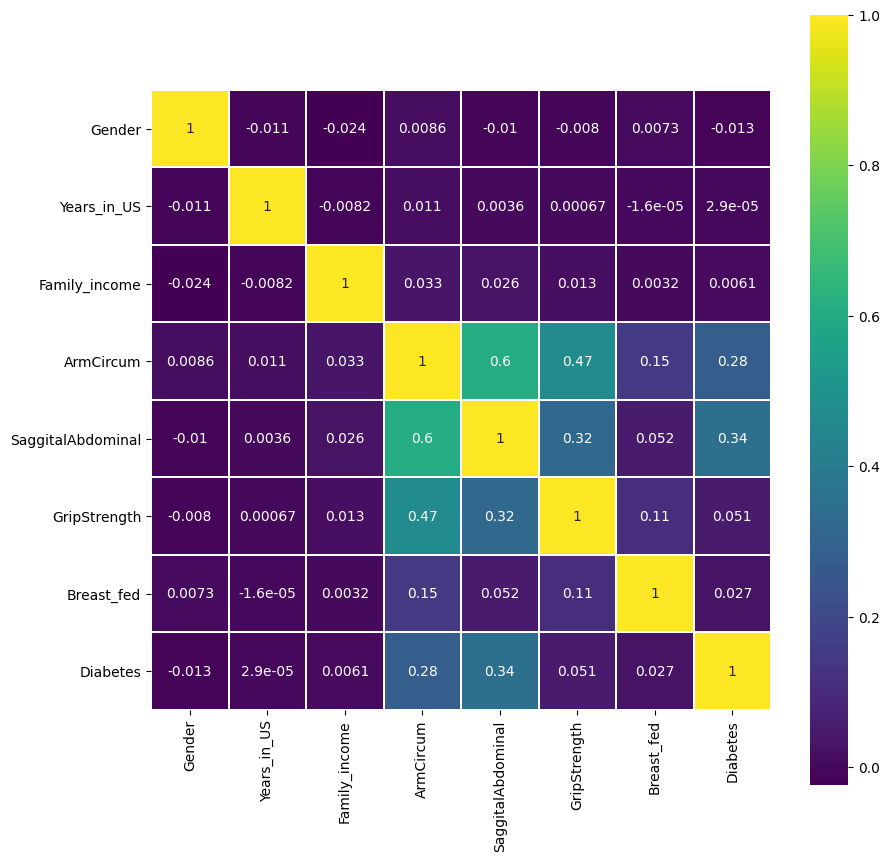

In [3]:
### Посмотрим как устроены данные
### Изобразим корреляционную матрицу

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

In [4]:
### Разделим выборку на трейн-тест

data = df.drop(['Diabetes'], axis=1)
target = df[['Diabetes']]

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target, 
                                                    test_size=0.25,
                                                    random_state=1)

Для того, чтобы использовать K-means, лучше будет отнормировать данные. 

In [15]:
### Воспользуемся StandardScaler

### Your code is here

scaler = StandardScaler()

X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

Обучим K-Means с параметрами `n_clusters` = 3, `tol` = 0.0005. Выбор параметров обусловлен тем, что у нас три возможных значения таргета. Но в целом основной подход подбора количества кластеров - по кривой зависимости внутрикластерного и межкластерного расстояний от количества кластеров.

Установите `random_state` = 1

In [38]:
### Your code is here

kmeans = KMeans(n_clusters=3, 
                tol=0.0005, 
               random_state=1)

kmeans.fit(X_train_sc)

print ("parameters: ", kmeans.get_params)
print ("preict: ", kmeans.predict)
print ("\nscore: %.2f" % kmeans.score(X_test_sc))

parameters:  <bound method BaseEstimator.get_params of KMeans(n_clusters=3, random_state=1, tol=0.0005)>
preict:  <bound method _BaseKMeans.predict of KMeans(n_clusters=3, random_state=1, tol=0.0005)>

score: -11044.42


Посчитаем качество на изначальных данных(нормированных). Для этого обучите с дефолтными параметрами `RandomForestClassifier`, `LogisticRegression`, `LinearSVC`. Там, где нужно, установите `random_state` = 1. (1б)

In [17]:
### Your code is here

### Обучаем RandomForest
from sklearn.metrics import accuracy_score

model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(X_train_sc, y_train)

print(f"accuracy для модели RandomForest: {accuracy_score(y_true=y_test, y_pred=model_rf.predict(X_test_sc)):.3f}")


accuracy для модели RandomForest: 0.886


In [18]:
### обучаем логистическую регрессию

model_lr = LogisticRegression()
model_lr.fit(X_train_sc, y_train)

print(f"accuracy для модели LogisticRegression: {accuracy_score(y_true=y_test, y_pred=model_lr.predict(X_test_sc)):.3f}")


accuracy для модели LogisticRegression: 0.888


In [19]:
### обучаем метод опорных векторов

model_svm = LinearSVC()

model_svm.fit(X_train_sc, y_train)

print(f"accuracy для модели SVM: {accuracy_score(y_true=y_test, y_pred=model_svm.predict(X_test_sc)):.3f}")

accuracy для модели SVM: 0.892


In [20]:
print(f"{accuracy_score(y_test, model_rf.predict(X_test_sc)):.3f}, {accuracy_score(y_test, model_lr.predict(X_test_sc)):.3f},\
 {accuracy_score(y_test, model_svm.predict(X_test_sc)):.3f}")

0.886, 0.888, 0.892


Добавьте в признаковое описание номер кластера и посчитайте качество с новым признаком! Стало ли качество хоть сколько-то лучше? (1б)

In [29]:
### Your code is here




In [26]:
### Добавьте в признаковое описание номер кластера
X_train_sc['kmeans_pred'] = kmeans.predict(X_train_sc)

In [28]:
X_test_sc['kmeans_pred'] = kmeans.predict(X_test_sc)

In [30]:
### посчитайте качество с новым признаком

model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(X_train_sc, y_train)

model_lr = LogisticRegression()
model_lr.fit(X_train_sc, y_train)

model_svm = LinearSVC()
model_svm.fit(X_train_sc, y_train)

print(f"{accuracy_score(y_test, model_rf.predict(X_test_sc)):.3f}, {accuracy_score(y_test, model_lr.predict(X_test_sc)):.3f},\
 {accuracy_score(y_test, model_svm.predict(X_test_sc)):.3f}")

0.888, 0.888, 0.892


Посчитаем расстояния от объектов до центров кластеров. Для этого воспользуемся методом `transform` обученного класса kmeans.

Обучим и посчитаем метрики исключительно на расстояниях до центра. Убедимся, что такой подход имеет право на существование, если данные позволяют, то качество не сильно должно пострадать. А в каких-то случаях может оказаться даже лучше! Таким образом можно снижать размерность данных. (2б)

In [40]:
# нужно зафитить заново, мы же колонку добавили kmeans_pred
kmeans.fit(X_train_sc)
### Посчитаем расстояния от объектов до центров кластеров. Для этого воспользуемся методом transform обученного класса kmeans
X_train_km = kmeans.transform(X_train_sc)
X_test_km = kmeans.transform(X_test_sc)

In [41]:
### Your code is here
### Обучим и посчитаем метрики исключительно на расстояниях до центра.
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(X_train_km, y_train)

model_lr = LogisticRegression()
model_lr.fit(X_train_km, y_train)

model_svm = LinearSVC()
model_svm.fit(X_train_km, y_train)

print(f"{accuracy_score(y_test, model_rf.predict(X_test_km)):.3f}, {accuracy_score(y_test, model_lr.predict(X_test_km)):.3f},\
 {accuracy_score(y_test, model_svm.predict(X_test_km)):.3f}")




0.882, 0.892, 0.892


### Бонусное задание

* Задача кластеризации может использоваться не только для специфических задач группировки данных, но и для оптимизации других методов. Вы уже знаете, что одна из основных проблем kNN в скорости его предсказания. В этом задании попробуем ускорить работу kNN с помощью кластеризации, не теряя при этом сильно в качестве.

Скачать данные можно здесь .

https://yadi.sk/d/aXYyLCTaBixiOg

* Обучите обычный kNN с одним соседом и измерьте качество, например, взвешенную f-меру, чтобы потом сравнить с нашей реализацией. 

* Введите полученное значение f-меры без округления.

In [78]:
df_2 = pd.read_csv('processed_vehicle_inssurance.csv')
print(df_2.shape)
df_2.head()

(381109, 11)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,2,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [84]:
X = df_2.drop(['Response'], axis=1)[:25000]
target = df_2[['Response']][:25000]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    target.values, 
                                                    test_size=0.2,
                                                    random_state=0)

In [85]:

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [87]:
%%time
from sklearn.metrics import f1_score
print(f"{f1_score(y_test, knn.predict(X_test), average='weighted')}")

0.8259679418155178
CPU times: user 245 ms, sys: 50 µs, total: 245 ms
Wall time: 245 ms
